<a href="https://colab.research.google.com/github/adityaravi9034/Potato-Plant-Disease/blob/main/Potatoes_Leaf_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

In [ ]:
pip install jovian opendatasets pandas numpy scikit-learn xgboost --quiet

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
#import shutil

#dir_to_move = '/content/drive/MyDrive/my resume/potato-disease/PlantVillage'
#shutil.copytree(dir_to_move, './PlantVillage')

In [ ]:
#import opendatasets as od

In [ ]:
#dataset_url = 'https://www.kaggle.com/datasets/arjuntejaswi/plant-village'

In [ ]:
#od.download(dataset_url)

In [ ]:
#data_dir = 'Plant Village'

In [12]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
###import shutil
###shutil.rmtree('/content/plant-village')
###used it to delete unnecessary datafiles 

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/PlantVillage",
 shuffle= True,
 image_size= (IMAGE_SIZE,IMAGE_SIZE),
 batch_size= (BATCH_SIZE))

Found 2152 files belonging to 3 classes.


In [14]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [15]:
len(dataset)

68

In [16]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape )
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0]


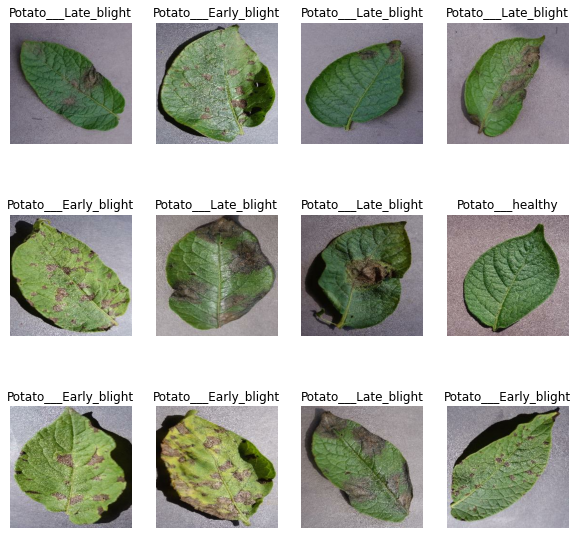

In [17]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
   ax = plt.subplot(3,4,i+1)
   plt.imshow(image_batch[i].numpy().astype("uint8"))
   plt.title(class_names[label_batch[i]])
   plt.axis("off")
    

In [18]:
len(dataset)

68

In [19]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [20]:
train_ds = dataset.take(54)
len(train_ds)

54

In [21]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [22]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [24]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [25]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [27]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle :
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds =ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds ,test_ds = get_dataset_partitions_tf(dataset)

In [29]:
len(train_ds)

54

In [30]:
len(val_ds)

6

In [31]:
len(test_ds)

8

In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)



In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history = model.fit(
     train_ds,
     epochs = 50,
     batch_size=BATCH_SIZE,
     verbose=1,
     validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 292s 5s/step - loss: 0.9007 - accuracy: 0.4664 - val_loss: 0.8451 - val_accuracy: 0.4948
Epoch 2/50
54/54 [==============================] - 283s 5s/step - loss: 0.7062 - accuracy: 0.6453 - val_loss: 0.6616 - val_accuracy: 0.7188
Epoch 3/50
54/54 [==============================] - 281s 5s/step - loss: 0.5375 - accuracy: 0.7610 - val_loss: 0.5228 - val_accuracy: 0.7552
Epoch 4/50
54/54 [==============================] - 285s 5s/step - loss: 0.4478 - accuracy: 0.8021 - val_loss: 0.4775 - val_accuracy: 0.8021
Epoch 5/50
54/54 [==============================] - 282s 5s/step - loss: 0.3539 - accuracy: 0.8559 - val_loss: 0.4377 - val_accuracy: 0.8021
Epoch 6/50
54/54 [==============================] - 278s 5s/step - loss: 0.2244 - accuracy: 0.9126 - val_loss: 0.2014 - val_accuracy: 0.9219
Epoch 7/50
54/54 [==============================] - 269s 5s/step - loss: 0.1898 - accuracy: 0.9306 - val_loss: 0.4427 - val_accuracy: 0.8750
Epoch 8/50
54

In [42]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 11s 1s/step - loss: 0.0057 - accuracy: 1.0000


In [43]:
scores

[0.005742360837757587, 1.0]

In [44]:
history

In [45]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
type(history.history['loss'])

list

In [48]:
len(history.history['loss'])

50

In [49]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9006738066673279,
 0.7062355875968933,
 0.5375489592552185,
 0.4478038251399994,
 0.3539349138736725]

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

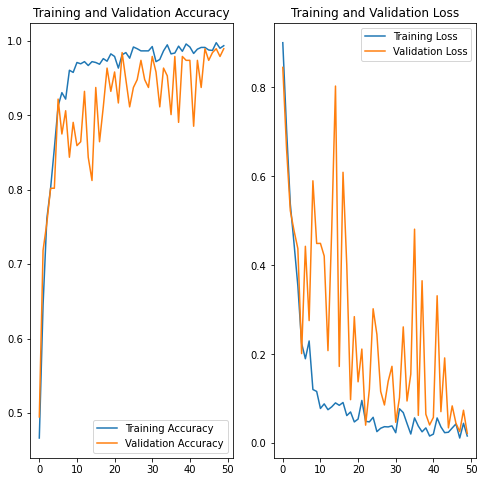

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 1s 1s/step
predicted label: Potato___healthy


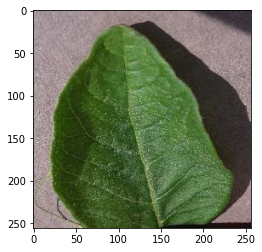

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict:


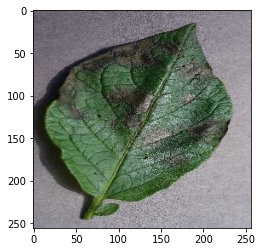

actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


In [54]:
import matplotlib.pyplot as plt
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict:")
    plt.imshow(first_image)
    plt.show()
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])
    print("predicted label:", class_names[predicted_label])


In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step


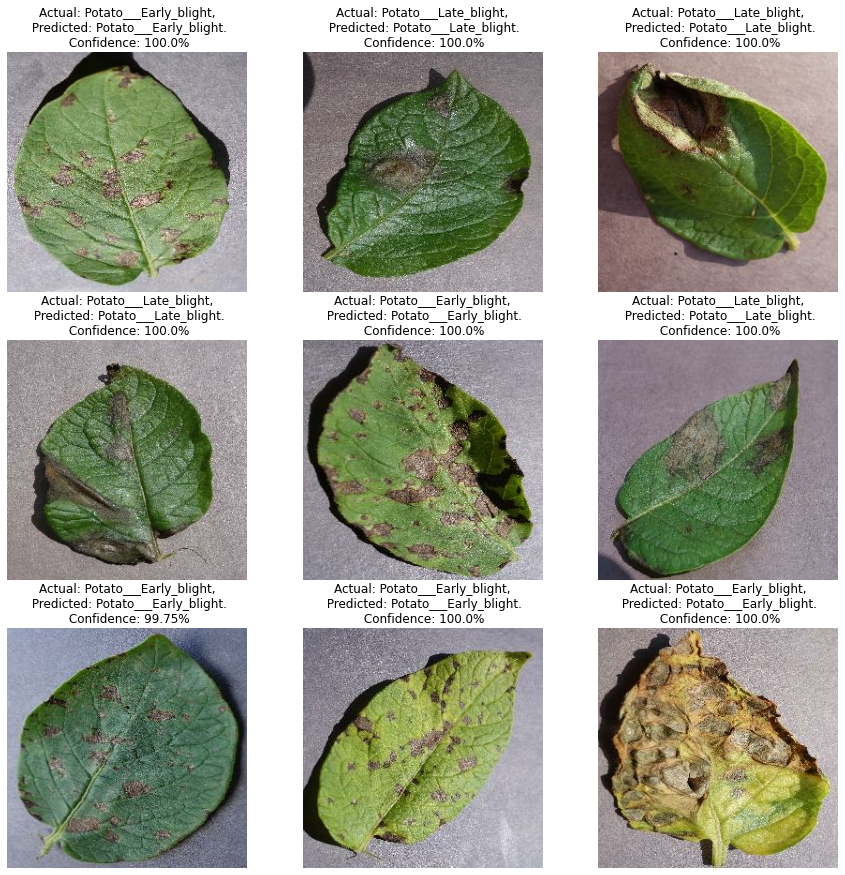

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [58]:
import os

if not os.path.exists("../models"):
    os.mkdir("../models")

model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")


In [62]:
import tensorflow as tf

# Define your untraced function
def untraced_function(inputs):
  # Your computation logic
  outputs = inputs + 1
  return outputs

# Wrap the untraced function in tf.function
@tf.function(input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])
def traced_function(inputs):
  return untraced_function(inputs)

# Use the traced function in your model
inputs = tf.constant([1, 2, 3], dtype=tf.float32)
outputs = traced_function(inputs)


In [63]:
model.save("../potatoes.h5")

In [69]:
shutil.make_archive('/path/to/PlantVillage', 'zip', '/content/PlantVillage')


'/path/to/PlantVillage.zip'

SyntaxError: ignored